In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import matplotlib as mpl, warnings

In [8]:
exps  = ['exp1','exp2','exp3','exp4']
funcs = ['sphere','rastrigin','rosenbrock']
freq = 4

In [9]:
# funcs
pat = re.compile('.*/(exp\d)/(\w*)/nonn/freq([0-9\.]+)div(\w+)/(\w+)_\w+.csv')
decode_keys = ['experiment','function','freq','div','method']
nn_pat = re.compile('.*/(exp\d)/(\w*)/nn/freq([0-9\.]+)\w+div([A-Za-z]+)/(\w+)_(\w+)_\w+.csv')
nn_decode_keys = ['experiment','function','freq','div','method','replace_mech']

def get_best_knowns():
    best_knowns = (pd.DataFrame(
        {f'{exp}/{func}':pd.read_csv(Path(f'../../data/results/{exp}/{func}/best_known.csv')).fitness.values
         for exp in exps for func in funcs}
    ).melt(value_name='fitness'))
    best_knowns['experiment'] = best_knowns['variable'].str.split('/').apply(lambda x: x[0])
    best_knowns['function'] = best_knowns['variable'].str.split('/').apply(lambda x: x[1])
    return best_knowns.drop('variable', axis=1)

def get_files(m): return list(path.glob(f'**/nonn/**/*{m}.csv'))
def get_nn_files(m): return list(path.glob(f'**/nn/**/*{m}.csv'))

def df_mean(df, m):
#     for n,d in df.groupby(['experiment', 'function', 'freq', 'method']):
#         import pdb;pdb.set_trace()
#     cols = df.columns[:100]
#     means = df.loc[:,cols].mean(axis=1)
#     df[m] = means
#     df.rename({'0': m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df#.drop(cols, axis=1)

def read_csv(f,m):
    df = pd.read_csv(f)
    df = df.mean().to_frame().T
    for k,v in zip(decode_keys,pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['div']
    df['method'] = df['method'].str.replace('noNNRestart_No', 'noNN_Rst')
    df.drop('div', axis=1, inplace=True)
    df = df_mean(df, m)
    return df

def read_nn_csv(f,m):
    df = pd.read_csv(f)
    df = df.mean().to_frame().T
    for k,v in zip(nn_decode_keys,nn_pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['replace_mech'] + '_' + df['div']
    df['method'] = df['method'].str.replace('NNnorm_Worst', 'NN')
    df.drop(['replace_mech','div'], axis=1, inplace=True)
    df = df_mean(df, m)
    return df

def get_data(m='fitness', normalize=False):
#     short_dict = {'NNnorm_Random':'NNR', 'NNnorm_Worst':'NNW', 'noNN_R':'noNN', 'noNN_RI': 'noNN_RI',
#                   'noNN_Cw':'noNN_Cw','noNN_No':'noNN_No', 'noNN_CwN':'noNN_CwN', 'noNN_CwcN':'noNN_CwcN','noNN_Cwc':'noNN_Cwc',  }
    files = get_files(m)
    nn_files = get_nn_files(m)
    data = pd.concat([read_csv(f,m) for f in files] + [read_nn_csv(f,m) for f in nn_files])
    #data.method = data.method.apply(lambda x: short_dict[x])
    if normalize:
        data_norm = (data.groupby(['experiment','function','freq','method'])[m.upper()].mean().reset_index()
                         .groupby(['experiment','function'])[m.upper()].min().reset_index()
                         .rename({m.upper():m.upper()+'_norm'}, axis=1))
        data = data.merge(data_norm, 'left')
        data[m.upper()+'_norm'] = data[m.upper()] / data[m.upper()+'_norm']
    return data.reset_index(drop=True)

def plot_one(exp, func, freq, ax, lbl_dict=None):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        lbl = row.method if lbl_dict is None else lbl_dict[row.method]
        ax.plot(row[:100].values, label=lbl, linewidth=2, alpha=0.65)

    return ax

path = Path(f'../../data/cluster_results')

df = get_data()
best_knowns = get_best_knowns()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

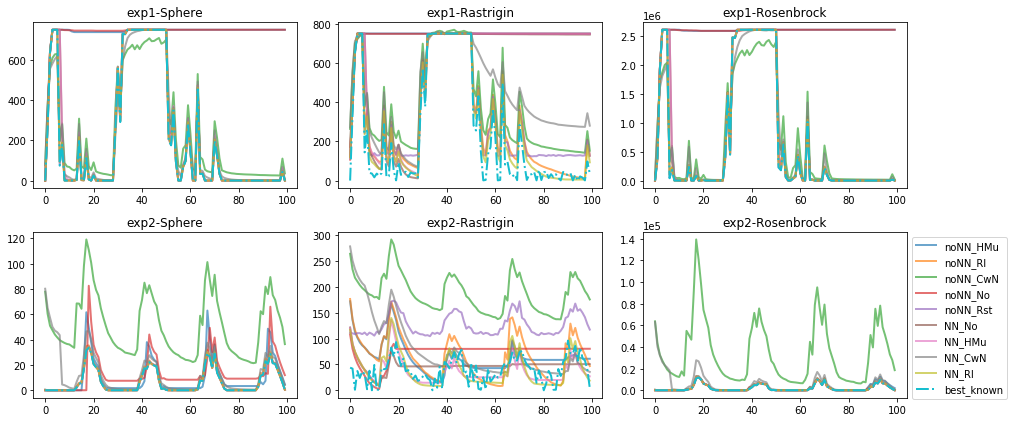

In [10]:
# Plot
fig,axs = plt.subplots(2, 3, figsize=(14,6))
lbl_dict = {'NNnorm_Worst_fitness' :'NNW',
            'NNnorm_Random_fitness':'NNR',
            'noNNReval_fitness'    :'noNN',
            'best_known'           :'best_known'}
lbl_dict = None

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax, lbl_dict)
        # plot best
        best_values = best_knowns.query(f'experiment == {exp!r} and function=={func!r}').fitness.values
        ax.plot(best_values, lw=2, ls='-.', label='best_known')
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
        if ax.get_ylim()[1] < 1e5:
            ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
ax.legend(loc='upper right', bbox_to_anchor=(0,0.2, 1.4, 0.8))#, bbox_to_anchor=(0,0, 0.5, 0.5))#best(0, -0.90, 0.5, 0.5)
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

fig.savefig(f'../../data/cluster_results/fitness{freq_lbl}.eps', dpi=400, format='eps')